In [12]:
from interarray.importer import load_repository
from interarray.plotting import gplot
from interarray.mesh import make_planar_embedding
from interarray.interarraylib import G_from_S
from interarray.heuristics import EW_presolver
from interarray.MILP import pyomo as omo
from interarray.pathfinding import PathFinder

In [2]:
from pyomo import environ as pyo

## Initialize MILP solver

In [3]:
cplexer = pyo.SolverFactory('cplex', solver_io='python')
cplexer.available(), type(cplexer)

(True, pyomo.solvers.plugins.solvers.cplex_direct.CPLEXDirect)

## Load interarray's locations

In [6]:
locations = load_repository()

## Optimize Race Bank 2

In [28]:
L = locations.race
capacity = 5

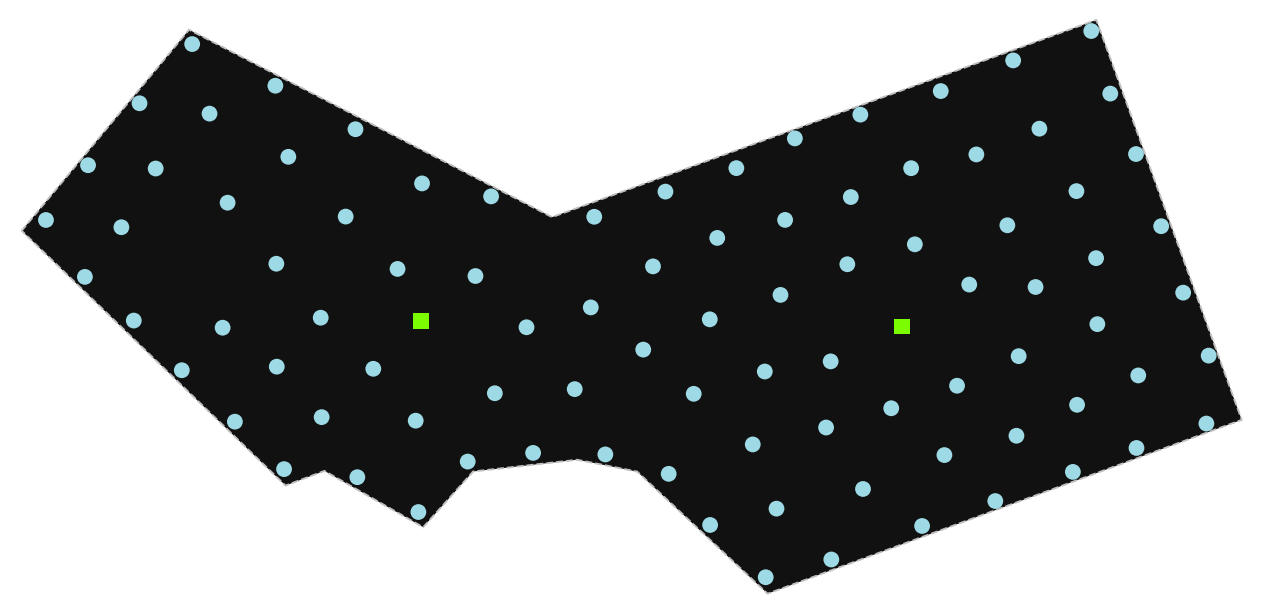

In [30]:
gplot(L);

In [31]:
P, A = make_planar_embedding(L)

Initial heuristic solution to warm-start the solver:

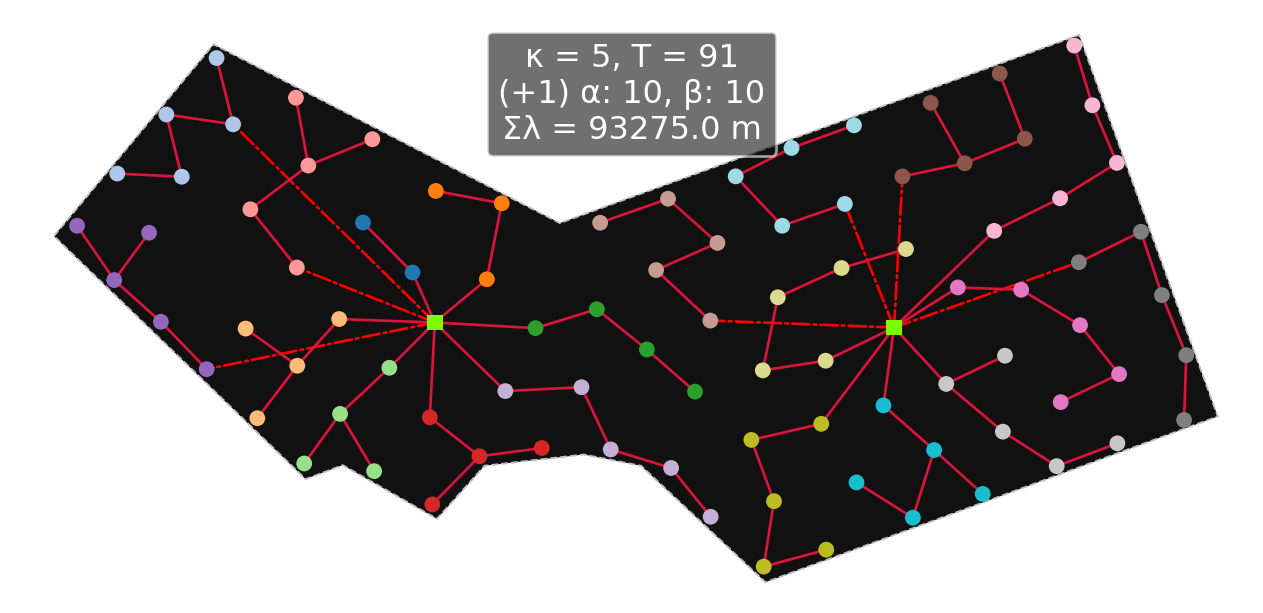

In [36]:
Sʹ = EW_presolver(A, capacity=capacity)
Gʹ = G_from_S(Sʹ, A)
gplot(Gʹ);

In [33]:
model = omo.make_min_length_model(
    A, capacity,
    gateXings_constraint=False,
    branching=True,
    gates_limit=False
)
omo.warmup_model(model, Sʹ);

In [34]:
cplexer.options.mipgap = 0.002  # relative lower-bound to objective-value gap
cplexer.options.timelimit = 20  # seconds
cplexer.options.parallel = -1  # opportunistic parallelism (non-deterministic)
cplexer.options.emphasis_mip = 4  # focus on producing solutions
print(f'Solving "{model.handle}": {{R={len(model.R)}, T={len(model.T)}, κ={model.k.value}}}\n')
result = cplexer.solve(model, warmstart=True, tee=True)

Solving "race": {M=2, N=91, k=5}

Version identifier: 22.1.2.0 | 2024-11-25 | 0edbb82fd
CPXPARAM_Read_DataCheck                          1
CPXPARAM_Parallel                                -1
CPXPARAM_Emphasis_MIP                            4
CPXPARAM_TimeLimit                               20
CPXPARAM_MIP_Tolerances_MIPGap                   0.002
1 of 1 MIP starts provided solutions.
MIP start 'm1' defined initial solution with objective 93274.5215.
Tried aggregator 1 time.
MIP Presolve eliminated 457 rows and 0 columns.
MIP Presolve modified 1894 coefficients.
Reduced MIP has 2736 rows, 2076 columns, and 9872 nonzeros.
Reduced MIP has 1038 binaries, 1038 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (8.40 ticks)
Probing time = 0.00 sec. (2.89 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 2736 rows, 2076 columns, and 9872 nonzeros.
Reduced MIP has 1038 binaries, 1038 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (6.43 ticks)
Pro

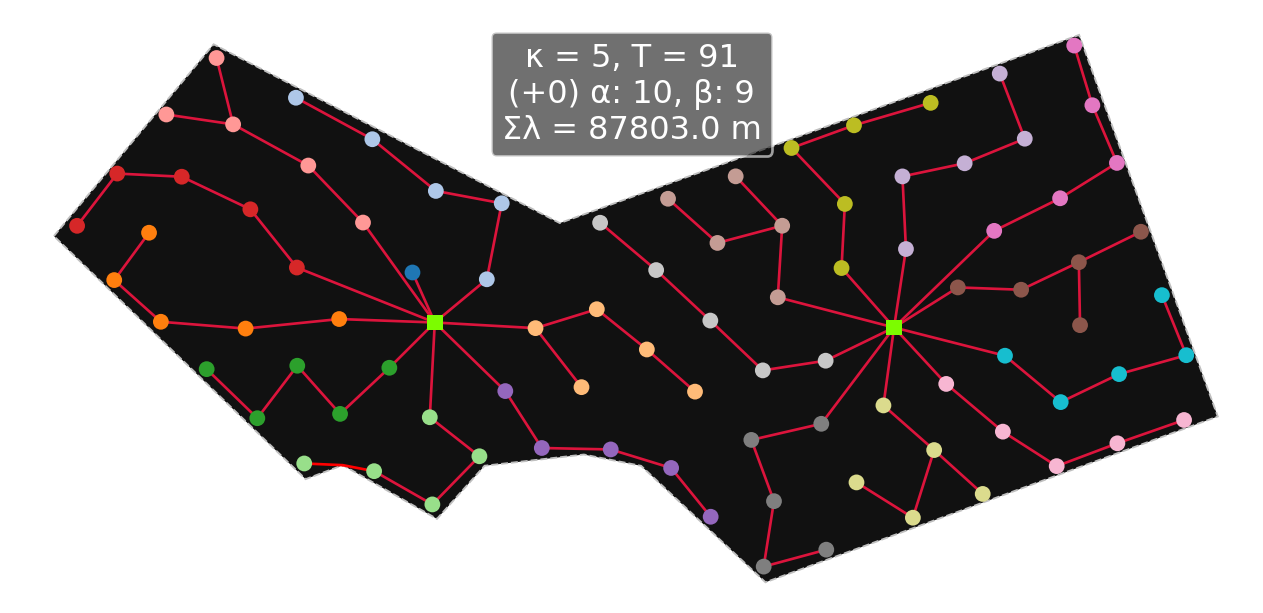

In [35]:
S = omo.S_from_solution(model, cplexer, result)
G = G_from_S(S, A)
H = PathFinder(G, planar=P, A=A).create_detours()
gplot(H);